## Analyze selection policies
#### Cifar-10, N=300, C=20, K=10
#### Selection policies = `{Random, fastest, maxSamples, fairShare, prioritizeUnavail}`

- Read trainer jsons from correct directory
- Construct a dict trainer_info = {trainer_id: {speed: a, samples: b, duration_unavail: c, num_classes: d}}
- Read the correct aggregator run file- get the last row to get the dict for trainer_ids -> rounds_participated
- Do for speed first: Create buckets. Get total % share of trainer updates per bucket

In [2]:
import os
import json
import ast
import re
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Note: can think about num_classes later if needed. Already
# correlated with num_samples and doesnt provide much additional info.
# Also, it should be done during json generation cause now you need to
# get the dataloader code here which is dataset specific and not
# clean.

def construct_trainer_dict(alpha, dataset_name):
    dir_name = f"config_dir{alpha}_num300_traceFail_48h"
    dir_path = os.path.join(".", dataset_name, "trainer", dir_name)

    trainer_info = {}

    # Walk through the directory and process each JSON file
    for filename in os.listdir(dir_path):
        if filename.startswith("trainer_") and filename.endswith(".json"):
            file_path = os.path.join(dir_path, filename)
            
            with open(file_path, "r") as file:
                print("processing file: ", file_path)
                data = json.load(file)
                
                # Extract trainer_id and runtime
                trainer_id = data.get("taskid")
                if trainer_id in trainer_info.keys():
                    print("Got duplicate trainer_id: ", trainer_id)
                hyperparameters = data.get("hyperparameters", {})
                num_samples = len(hyperparameters.get("trainer_indices_list"))
                training_delay_s = hyperparameters.get("training_delay_s")
                failure_durations_s = ast.literal_eval(hyperparameters.get("failure_durations_s"))
                
                if trainer_id is not None:
                    if trainer_id not in trainer_info.keys():
                        trainer_info[trainer_id] = {}

                    # Populate the trainer_info dictionary
                    if training_delay_s is not None:
                        trainer_info[trainer_id]["training_delay_s"] = float(training_delay_s)
                    
                    if num_samples is not None:
                        trainer_info[trainer_id]["num_samples"] = num_samples

                    if failure_durations_s is not None:
                        trainer_info[trainer_id]["failure_durations_s"] = failure_durations_s

    return trainer_info

In [7]:
alpha = 0.1
dataset_name = "async_cifar10"
trainer_dict = construct_trainer_dict(alpha, dataset_name)
print(trainer_dict)

processing file:  ./async_cifar10/trainer/config_dir0.1_num300_traceFail_48h/trainer_244.json
processing file:  ./async_cifar10/trainer/config_dir0.1_num300_traceFail_48h/trainer_65.json
processing file:  ./async_cifar10/trainer/config_dir0.1_num300_traceFail_48h/trainer_77.json
processing file:  ./async_cifar10/trainer/config_dir0.1_num300_traceFail_48h/trainer_81.json
processing file:  ./async_cifar10/trainer/config_dir0.1_num300_traceFail_48h/trainer_284.json
Got duplicate trainer_id:  505f9fc483cf4df68a2409257b5fad7d3c580370
processing file:  ./async_cifar10/trainer/config_dir0.1_num300_traceFail_48h/trainer_72.json
processing file:  ./async_cifar10/trainer/config_dir0.1_num300_traceFail_48h/trainer_258.json
Got duplicate trainer_id:  505f9fc483cf4df68a2409257b5fad7d3c580370
processing file:  ./async_cifar10/trainer/config_dir0.1_num300_traceFail_48h/trainer_224.json
Got duplicate trainer_id:  505f9fc483cf4df68a2409257b5fad7d3c580370
processing file:  ./async_cifar10/trainer/config

In [5]:
len(trainer_dict)

100

In [12]:
def read_agg_log_file(agg_log_file_name, dataset_name):
    dir_path = os.path.join(".", dataset_name, "aggregator", agg_log_file_name)

    with open(dir_path, "r") as file:
        lines = file.readlines()

    # Initialize to None to handle cases where the string is not found
    last_dict_str = None

    # Find the last occurrence of "self._updates_recevied:"
    for line in reversed(lines):
        if "self._updates_recevied:" in line:
            # Regex to capture the first dictionary after "self._updates_recevied:"
            match = re.search(r"self._updates_recevied:\s*(\{.*?\})", line)
            if match:
                last_dict_str = match.group(1).strip()  # Capture the first dictionary and strip whitespace
                break

    if last_dict_str:
        try:
            # Debugging: print the extracted string
            print(f"Extracted dictionary string: {repr(last_dict_str)}")
            
            # Attempt to parse with ast.literal_eval
            return ast.literal_eval(last_dict_str)
        except (SyntaxError, ValueError) as e:
            print(f"ast.literal_eval error: {e}")
            # Fallback to json.loads
            try:
                json_str = last_dict_str.replace("'", '"')  # Convert single quotes to double quotes
                return json.loads(json_str)
            except json.JSONDecodeError as e:
                print(f"json.loads error: {e}")
                raise ValueError("Failed to parse dictionary from log file.")
    
    # If the string wasn't found, return an empty dictionary or handle as needed
    return {}


In [104]:
##### ALPHA = 100
# agg_log_file_name = "agg_sheph_13_08_05_38_alpha100_cifar_60acc_fastest.log"

# agg_log_file_name = "agg_sheph_13_08_10_53_alpha100_cifar_60acc_maxSamples.log"


#### ALPHA = 0.1
agg_log_file_name = "agg_sheph_14_08_09_54_alpha0.1_cifar_60acc_fastest.log"

# agg_log_file_name = "agg_sheph_14_08_20_10_alpha0.1_cifar_60acc_maxSamples.log"

agg_log_trainer_updates = read_agg_log_file(agg_log_file_name, dataset_name)

Extracted dictionary string: "{'505f9fc483cf4df68a2409257b5fad7d3c580370': 1, '505f9fc483cf4df68a2409257b5fad7d3c580375': 2286, '505f9fc483cf4df68a2409257b5fad7d3c580372': 1, '505f9fc483cf4df68a2409257b5fad7d3c580376': 1699, '505f9fc483cf4df68a2409257b5fad7d3c580374': 581, '505f9fc483cf4df68a2409257b5fad7d3c580383': 599, '505f9fc483cf4df68a2409257b5fad7d3c580379': 1381, '505f9fc483cf4df68a2409257b5fad7d3c580384': 675, '505f9fc483cf4df68a2409257b5fad7d3c580382': 502, '505f9fc483cf4df68a2409257b5fad7d3c580380': 333, '505f9fc483cf4df68a2409257b5fad7d3c580388': 617, '505f9fc483cf4df68a2409257b5fad7d3c580385': 133, '505f9fc483cf4df68a2409257b5fad7d3c580387': 273, '505f9fc483cf4df68a2409257b5fad7d3c580390': 1249, '505f9fc483cf4df68a2409257b5fad7d3c580386': 528, '505f9fc483cf4df68a2409257b5fad7d3c580391': 460, '505f9fc483cf4df68a2409257b5fad7d3c580395': 1514, '505f9fc483cf4df68a2409257b5fad7d3c580393': 714, '505f9fc483cf4df68a2409257b5fad7d3c580394': 248, '505f9fc483cf4df68a2409257b5fad7d3c58

In [105]:
# calculate update share for each trainer and store in dict
total_updates = 0
total_updates = sum(agg_log_trainer_updates.values())

per_trainer_update_share = {}

for trainer, num_updates in agg_log_trainer_updates.items():
    trainer_perc_update_share = (num_updates/total_updates)*100
    per_trainer_update_share[trainer] = trainer_perc_update_share

top_10_trainers = dict(sorted(per_trainer_update_share.items(), key = lambda item: item[1], reverse=True))

top_10_trainers

{'505f9fc483cf4df68a2409257b5fad7d3c580375': 3.7346838751837934,
 '505f9fc483cf4df68a2409257b5fad7d3c580440': 3.47165495834014,
 '505f9fc483cf4df68a2409257b5fad7d3c580404': 2.921091324946904,
 '505f9fc483cf4df68a2409257b5fad7d3c580416': 2.7952948864564613,
 '505f9fc483cf4df68a2409257b5fad7d3c580376': 2.7756902466917173,
 '505f9fc483cf4df68a2409257b5fad7d3c580429': 2.7511844469857865,
 '505f9fc483cf4df68a2409257b5fad7d3c580449': 2.5600392092795294,
 '505f9fc483cf4df68a2409257b5fad7d3c580395': 2.473452050318575,
 '505f9fc483cf4df68a2409257b5fad7d3c580461': 2.448946250612645,
 '505f9fc483cf4df68a2409257b5fad7d3c580418': 2.403202091161575,
 '505f9fc483cf4df68a2409257b5fad7d3c580373': 2.3983009312203887,
 '505f9fc483cf4df68a2409257b5fad7d3c580379': 2.2561672929259924,
 '505f9fc483cf4df68a2409257b5fad7d3c580465': 2.0666557752001307,
 '505f9fc483cf4df68a2409257b5fad7d3c580390': 2.0405162555138046,
 '505f9fc483cf4df68a2409257b5fad7d3c580463': 1.8624407776507108,
 '505f9fc483cf4df68a2409257b5fa

In [94]:
# create buckets for based on trainer speed
speed_buckets = np.linspace(0, 60, num=61)

In [95]:
speed_buckets

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60.])

In [96]:
share_per_bucket = {}
for item in speed_buckets:
    share_per_bucket[item] = 0

print("share_per_bucket: ", share_per_bucket)

for trainer_id, update_count in agg_log_trainer_updates.items():
    # find the trainer speed
    trainer_speed = trainer_dict[trainer_id]["training_delay_s"]

    # find the trainer speed bucket
    found_index_for_speed = np.argwhere(np.array(speed_buckets)>trainer_speed)[0][0]

    # store current bucket participation value
    curr_bucket_share = share_per_bucket[speed_buckets[found_index_for_speed]]

    # update with current trainer participation value
    update_share = per_trainer_update_share[trainer_id]
    new_bucket_share = curr_bucket_share + update_share
    share_per_bucket[speed_buckets[found_index_for_speed]] = new_bucket_share

share_per_bucket:  {0.0: 0, 1.0: 0, 2.0: 0, 3.0: 0, 4.0: 0, 5.0: 0, 6.0: 0, 7.0: 0, 8.0: 0, 9.0: 0, 10.0: 0, 11.0: 0, 12.0: 0, 13.0: 0, 14.0: 0, 15.0: 0, 16.0: 0, 17.0: 0, 18.0: 0, 19.0: 0, 20.0: 0, 21.0: 0, 22.0: 0, 23.0: 0, 24.0: 0, 25.0: 0, 26.0: 0, 27.0: 0, 28.0: 0, 29.0: 0, 30.0: 0, 31.0: 0, 32.0: 0, 33.0: 0, 34.0: 0, 35.0: 0, 36.0: 0, 37.0: 0, 38.0: 0, 39.0: 0, 40.0: 0, 41.0: 0, 42.0: 0, 43.0: 0, 44.0: 0, 45.0: 0, 46.0: 0, 47.0: 0, 48.0: 0, 49.0: 0, 50.0: 0, 51.0: 0, 52.0: 0, 53.0: 0, 54.0: 0, 55.0: 0, 56.0: 0, 57.0: 0, 58.0: 0, 59.0: 0, 60.0: 0}


In [86]:
# Fastest
share_per_bucket

{0.0: 0,
 1.0: 0,
 2.0: 0,
 3.0: 5.093938898872732,
 4.0: 8.07057670315308,
 5.0: 5.368403855579153,
 6.0: 15.899362849207646,
 7.0: 1.8019931383760823,
 8.0: 7.12301911452377,
 9.0: 7.570658389152099,
 10.0: 1.968632576376409,
 11.0: 6.534879921581441,
 12.0: 4.2019277895768665,
 13.0: 7.131187714425748,
 14.0: 2.2725044927299463,
 15.0: 5.028590099656919,
 16.0: 4.741055383107335,
 17.0: 2.0111092958666887,
 18.0: 2.06338833523934,
 19.0: 2.2430975330828296,
 20.0: 0.684528671785656,
 21.0: 0.8838425093938899,
 22.0: 2.1826498938082013,
 23.0: 1.4932200620813592,
 24.0: 1.1370691063551708,
 25.0: 0.7662146708054239,
 26.0: 0,
 27.0: 0,
 28.0: 0.9361215487665414,
 29.0: 1.1141970266296357,
 30.0: 0,
 31.0: 0.8756739094919131,
 32.0: 0,
 33.0: 0,
 34.0: 0,
 35.0: 0,
 36.0: 0,
 37.0: 0.44927299460872405,
 38.0: 0,
 39.0: 0.2744649567064205,
 40.0: 0,
 41.0: 0,
 42.0: 0,
 43.0: 0,
 44.0: 0,
 45.0: 0,
 46.0: 0,
 47.0: 0,
 48.0: 0.0784185590589773,
 49.0: 0,
 50.0: 0,
 51.0: 0,
 52.0: 0,
 

In [97]:
# Max Samples
share_per_bucket

{0.0: 0,
 1.0: 0,
 2.0: 0,
 3.0: 4.885321100917432,
 4.0: 6.607142857142858,
 5.0: 5.5504587155963305,
 6.0: 15.440694626474443,
 7.0: 1.8528833551769333,
 8.0: 6.707077326343381,
 9.0: 8.309305373525556,
 10.0: 1.9528178243774574,
 11.0: 6.420380078636958,
 12.0: 4.252948885976409,
 13.0: 7.015072083879423,
 14.0: 2.2771952817824377,
 15.0: 5.03440366972477,
 16.0: 4.988532110091744,
 17.0: 2.336173001310616,
 18.0: 2.1969200524246393,
 19.0: 2.3820445609436436,
 20.0: 0.942005242463958,
 21.0: 1.115661861074705,
 22.0: 2.285386631716907,
 23.0: 1.5334207077326343,
 24.0: 1.1713630406290956,
 25.0: 0.8191349934469201,
 26.0: 0,
 27.0: 0,
 28.0: 0.942005242463958,
 29.0: 1.2057667103538663,
 30.0: 0,
 31.0: 0.9567496723460026,
 32.0: 0,
 33.0: 0,
 34.0: 0,
 35.0: 0,
 36.0: 0,
 37.0: 0.47673656618610744,
 38.0: 0,
 39.0: 0.32929226736566186,
 40.0: 0,
 41.0: 0,
 42.0: 0,
 43.0: 0,
 44.0: 0,
 45.0: 0,
 46.0: 0,
 47.0: 0,
 48.0: 0.01310615989515072,
 49.0: 0,
 50.0: 0,
 51.0: 0,
 52.0: 0,

In [78]:
#### Based on num samples
max_samples = -1
for key, val in trainer_dict.items():
    curr_trainer_samples = val['num_samples']
    if max_samples < curr_trainer_samples:
        max_samples = curr_trainer_samples

print("max samples: ", max_samples)

max samples:  687


In [98]:
# create buckets for based on trainer samples
sample_buckets = np.linspace(0, 700, num=20)

In [99]:
sample_buckets

array([  0.        ,  36.84210526,  73.68421053, 110.52631579,
       147.36842105, 184.21052632, 221.05263158, 257.89473684,
       294.73684211, 331.57894737, 368.42105263, 405.26315789,
       442.10526316, 478.94736842, 515.78947368, 552.63157895,
       589.47368421, 626.31578947, 663.15789474, 700.        ])

In [100]:
share_per_bucket = {}
for item in sample_buckets:
    share_per_bucket[item] = 0

print("share_per_bucket: ", share_per_bucket)

for trainer_id, update_count in agg_log_trainer_updates.items():
    # find the trainer samples
    trainer_samples = trainer_dict[trainer_id]["num_samples"]

    # find the trainer speed bucket
    found_index_for_sample = np.argwhere(np.array(sample_buckets)>trainer_samples)[0][0]

    print("found_index_for_sample: ", found_index_for_sample)

    # store current bucket participation value
    curr_bucket_share = share_per_bucket[sample_buckets[found_index_for_sample]]

    # update with current trainer participation value
    update_share = per_trainer_update_share[trainer_id]
    new_bucket_share = curr_bucket_share + update_share
    share_per_bucket[sample_buckets[found_index_for_sample]] = new_bucket_share

share_per_bucket:  {0.0: 0, 36.8421052631579: 0, 73.6842105263158: 0, 110.5263157894737: 0, 147.3684210526316: 0, 184.21052631578948: 0, 221.0526315789474: 0, 257.89473684210526: 0, 294.7368421052632: 0, 331.5789473684211: 0, 368.42105263157896: 0, 405.2631578947369: 0, 442.1052631578948: 0, 478.94736842105266: 0, 515.7894736842105: 0, 552.6315789473684: 0, 589.4736842105264: 0, 626.3157894736843: 0, 663.1578947368422: 0, 700.0: 0}
found_index_for_sample:  6
found_index_for_sample:  1
found_index_for_sample:  11
found_index_for_sample:  6
found_index_for_sample:  8
found_index_for_sample:  2
found_index_for_sample:  1
found_index_for_sample:  2
found_index_for_sample:  1
found_index_for_sample:  4
found_index_for_sample:  11
found_index_for_sample:  2
found_index_for_sample:  6
found_index_for_sample:  9
found_index_for_sample:  3
found_index_for_sample:  5
found_index_for_sample:  2
found_index_for_sample:  1
found_index_for_sample:  5
found_index_for_sample:  11
found_index_for_sampl

In [101]:
# max samples
share_per_bucket

{0.0: 0,
 36.8421052631579: 13.77948885976409,
 73.6842105263158: 17.291939711664483,
 110.5263157894737: 20.58813892529489,
 147.3684210526316: 4.233289646133683,
 184.21052631578948: 4.80832241153342,
 221.0526315789474: 8.710681520314548,
 257.89473684210526: 1.1795543905635648,
 294.7368421052632: 8.417431192660551,
 331.5789473684211: 5.570117955439057,
 368.42105263157896: 0.6323722149410222,
 405.2631578947369: 7.696592398427262,
 442.1052631578948: 1.862712975098296,
 478.94736842105266: 2.511467889908257,
 515.7894736842105: 0.9043250327653997,
 552.6315789473684: 0,
 589.4736842105264: 0,
 626.3157894736843: 0,
 663.1578947368422: 0,
 700.0: 1.813564875491481}

In [102]:
sum(share_per_bucket.values())

100.00000000000001

In [90]:
# fastest
share_per_bucket

{0.0: 0,
 36.8421052631579: 15.089037738931548,
 73.6842105263158: 18.57049501715406,
 110.5263157894737: 20.962261068452868,
 147.3684210526316: 3.920927952948865,
 184.21052631578948: 4.616892664597288,
 221.0526315789474: 8.142460382290476,
 257.89473684210526: 1.148505146217938,
 294.7368421052632: 7.551053749387356,
 331.5789473684211: 5.389642215324293,
 368.42105263157896: 0.6306159124326091,
 405.2631578947369: 7.307629472308447,
 442.1052631578948: 1.800359418395687,
 478.94736842105266: 2.308446332298644,
 515.7894736842105: 0.8969122692370528,
 552.6315789473684: 0,
 589.4736842105264: 0,
 626.3157894736843: 0,
 663.1578947368422: 0,
 700.0: 1.6647606600228722}

In [103]:
per_trainer_update_share_max_samples = per_trainer_update_share

In [106]:
per_trainer_update_share_fastest = per_trainer_update_share

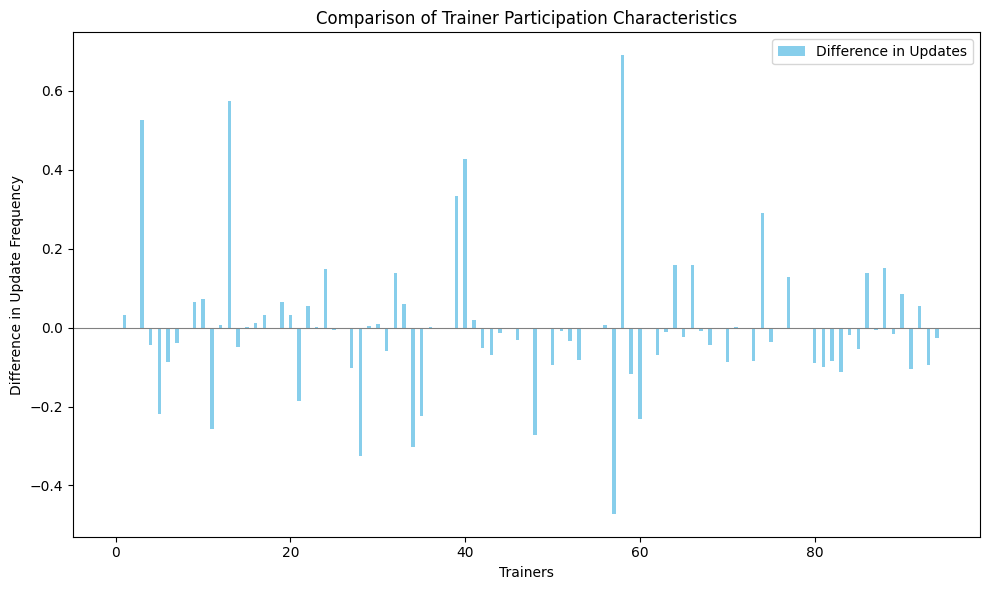

In [110]:
# Step 1: Identify common trainers
common_trainers = set(per_trainer_update_share_max_samples.keys()).intersection(
    per_trainer_update_share_fastest.keys()
)

# Step 2: Calculate differences
differences = {}
for trainer in common_trainers:
    diff = (
        per_trainer_update_share_fastest[trainer]
        - per_trainer_update_share_max_samples[trainer]
    )
    differences[trainer] = diff

# Step 3: Visualization

# Sorting for better visualization (optional)
sorted_trainers = sorted(differences.keys())
sorted_diffs = [differences[trainer] for trainer in sorted_trainers]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.4

x = np.arange(len(sorted_trainers))
plt.bar(x, sorted_diffs, color="skyblue", width=bar_width, label="Difference in Updates")

# Adding labels and title
plt.xlabel("Trainers")
plt.ylabel("Difference in Update Frequency")
plt.title("Comparison of Trainer Participation Characteristics")
# plt.xticks(x, sorted_trainers, rotation=45, ha="right")
plt.axhline(0, color='grey', linewidth=0.8)  # Add a horizontal line at y=0 for reference

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()

In [111]:
sorted_diffs

[-4.550006498480006e-06,
 0.031154697437414947,
 -4.550006498480006e-06,
 0.5257583362007294,
 -0.04360030344796273,
 -0.2200998731779369,
 -0.08636742041182144,
 -0.03955481237593195,
 -0.0007322833988142596,
 0.0641620504620346,
 0.07220699724622903,
 -0.257476570678302,
 0.0059072466722321915,
 0.5739455814940422,
 -0.0489428140195014,
 0.0010331191225960157,
 0.012342026450847143,
 0.033161517950685615,
 -0.001169084022668354,
 0.06531239916382657,
 0.031997251581956654,
 -0.18557924152141092,
 0.05409074490136967,
 0.0005098683752708388,
 0.14874693891621593,
 -0.00498252476327643,
 -0.0018109025863950468,
 -0.10338792413287057,
 -0.32624242477447507,
 0.003418125470122879,
 0.008164317542919353,
 -0.05890465177676152,
 0.13930888720116386,
 0.06105814308774771,
 -0.3028379942886177,
 -0.22307745096003007,
 0.0016246199673984009,
 -0.0008963512802004914,
 -4.550006498480006e-06,
 0.3325420425953408,
 0.4268743832064721,
 0.020178208230993866,
 -0.052920322641496154,
 -0.0684010506

In [116]:
(max(sorted_diffs)/100)*total_updates

422.37074049803414

In [117]:
(min(sorted_diffs)/100)*total_updates

-288.7459043250327

In [115]:
total_updates

61210

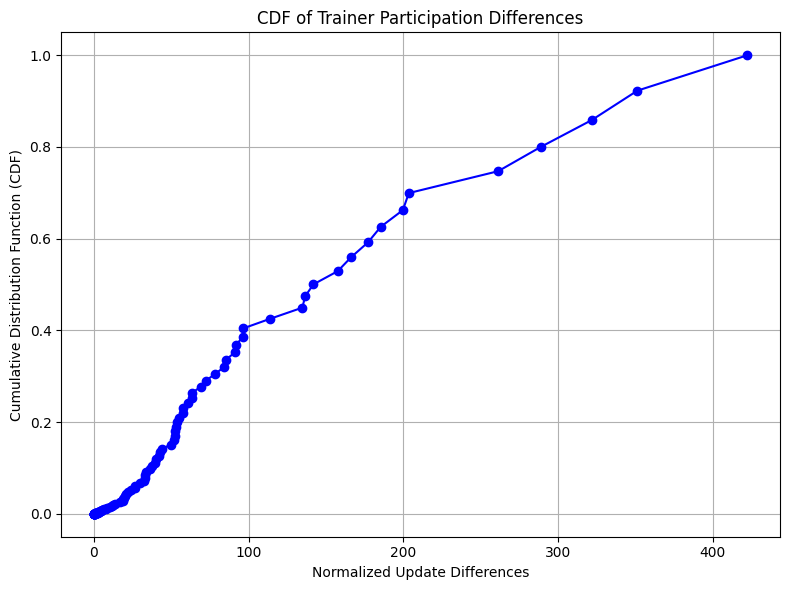

In [118]:
# Step 1: Identify common trainers
common_trainers = set(per_trainer_update_share_max_samples.keys()).intersection(
    per_trainer_update_share_fastest.keys()
)

# Step 2: Calculate normalized differences and apply modulus
normalized_differences = []
for trainer in common_trainers:
    diff = per_trainer_update_share_fastest[trainer] - per_trainer_update_share_max_samples[trainer]
    normalized_diff = (abs(diff) / 100) * total_updates
    normalized_differences.append(normalized_diff)

# Step 3: Sort the normalized differences
sorted_normalized_differences = sorted(normalized_differences)

# Step 4: Compute the cumulative distribution function (CDF)
cdf = np.cumsum(sorted_normalized_differences) / np.sum(sorted_normalized_differences)

# Step 5: Plot the CDF
plt.figure(figsize=(8, 6))
plt.plot(sorted_normalized_differences, cdf, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel("Normalized Update Differences")
plt.ylabel("Cumulative Distribution Function (CDF)")
plt.title("CDF of Trainer Participation Differences")
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [119]:
len(trainer_dict)

100

In [121]:
len(trainer_dict.keys())

100

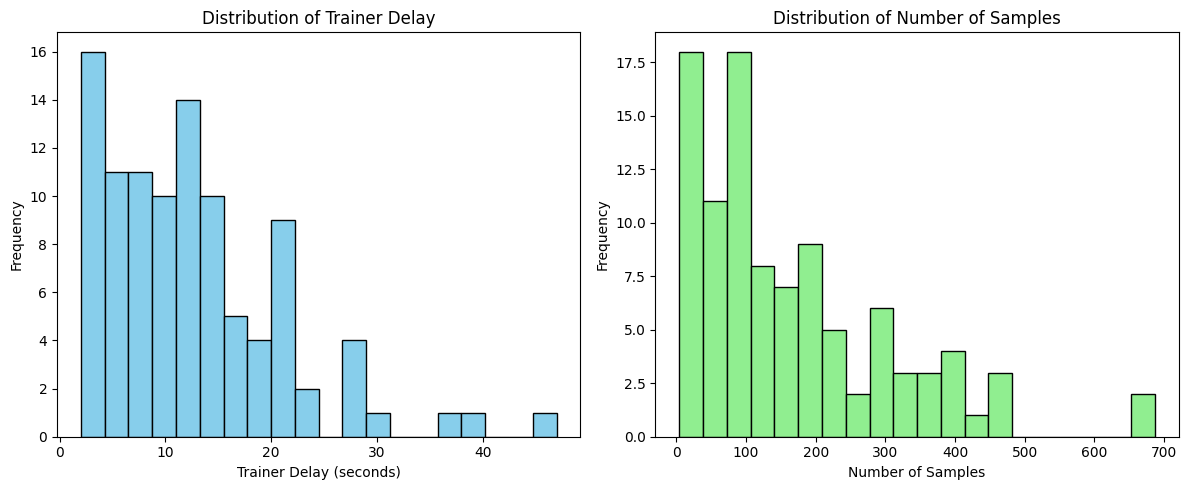

In [123]:
# Step 1: Extract the values
trainer_delays = [trainer_info["training_delay_s"] for trainer_info in trainer_dict.values()]
num_samples = [trainer_info["num_samples"] for trainer_info in trainer_dict.values()]

# Step 2: Create plots

# Plot 1: Distribution of Trainer Delay
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(trainer_delays, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Trainer Delay (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Trainer Delay")

# Plot 2: Distribution of Number of Samples
plt.subplot(1, 2, 2)
plt.hist(num_samples, bins=20, color='lightgreen', edgecolor='black')
plt.xlabel("Number of Samples")
plt.ylabel("Frequency")
plt.title("Distribution of Number of Samples")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()